In [5]:
import numpy as  np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
#from pandas import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import warnings
import itertools
from itertools import product
from tqdm import tqdm_notebook
import datetime 
#from datetime import datetime
%matplotlib inline
#pd.plotting.register_matplotlib_converters()

In [6]:
dataset = pd.read_csv("./arima.csv", parse_dates=[0])
dataset = dataset.set_index('Timestamp').asfreq(freq='5min')

dataset.drop(columns=[
    'CPU cores',
    'CPU capacity provisioned [MHZ]',
    'CPU usage [MHZ]',
    'Memory capacity provisioned [KB]',
    'Memory usage [KB]',
    'Memory usage [%]',
    'Disk read throughput [KB/s]',
    'Disk write throughput [KB/s]',
    'Disk size [GB]',
    'Network received throughput [KB/s]',
    'Network transmitted throughput [KB/s]'
] , inplace=True)


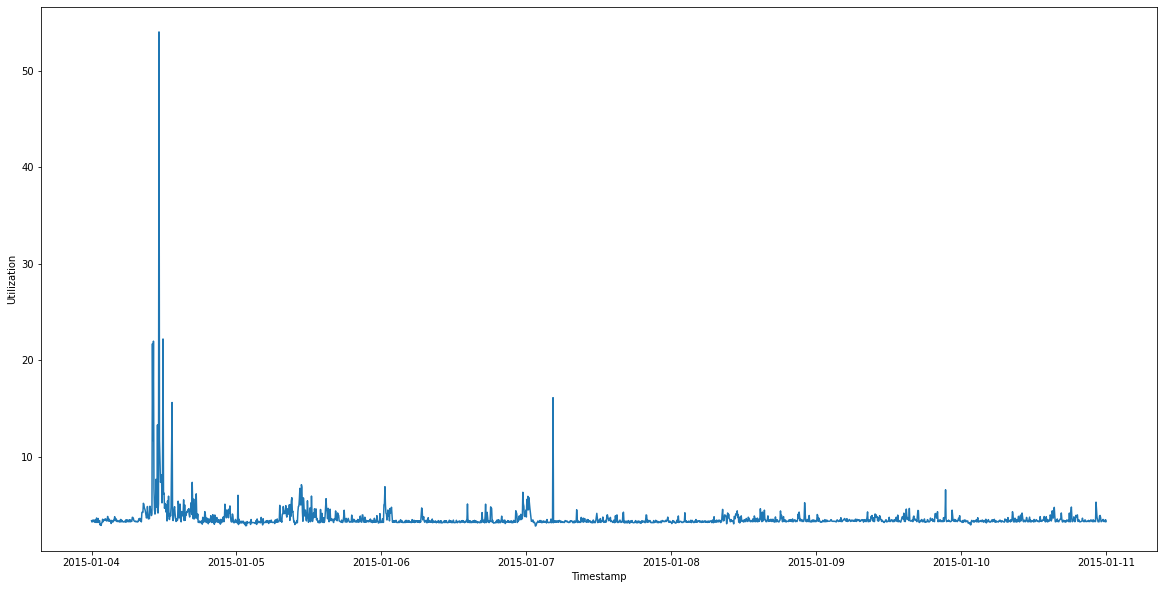

In [7]:
plt.figure(figsize=(20, 10))
plt.xlabel("Timestamp")
plt.ylabel("Utilization")
plt.plot(dataset)
plt.show()

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [11]:
moving_average(dataset['CPU usage [%]'],dataset.size) 

3.6315865146256816

In [12]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
      # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

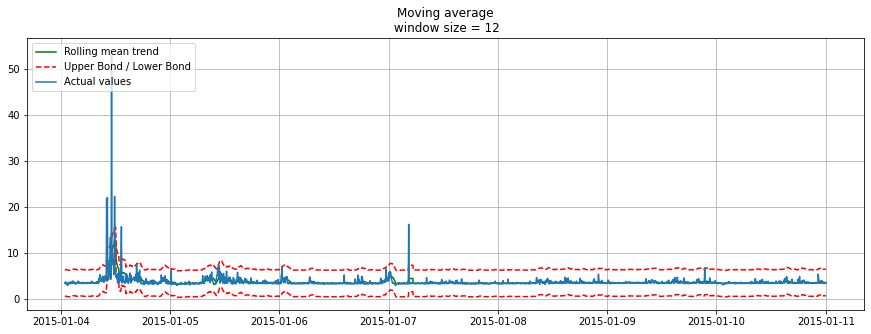

In [13]:
#dataset.CPU_usage_percent
plotMovingAverage(dataset['CPU usage [%]'],12,plot_intervals=True)

In [14]:
def test_Stationary(timeSeries):
    #detrolstat
    movingAverage = timeSeries.rolling(window=12).mean()
    movingStd = timeSeries.rolling(window=12).std()

    #plotrollinstat
    original = plt.plot(timeSeries, color='blue', label='original')
    mean = plt.plot(movingAverage, color='red', label='Rolling mean')
    std = plt.plot(movingStd, color='green', label='Rolling std')
    
    plt.legend(loc='best')
    plt.title('Rolling mean and std dev')
    plt.show(block=False)

    #df
    dftest = adfuller(timeSeries['CPU usage [%]'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p', 'lags', 'number'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' % key] = value
    print(dfoutput)

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

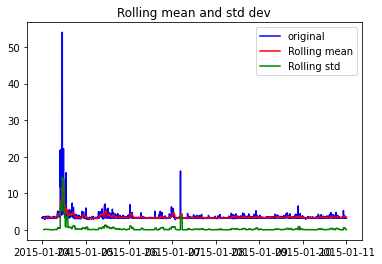

Test Statistic            -5.483397
p                          0.000002
lags                      26.000000
number                  1990.000000
Critical value (1%)       -3.433640
Critical value (5%)       -2.862993
Critical value (10%)      -2.567544
dtype: float64


/home/cdap/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


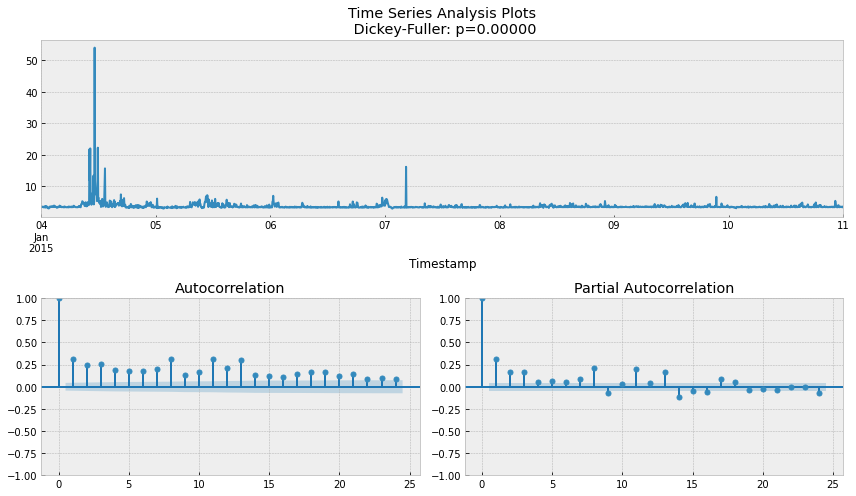

In [16]:
test_Stationary(dataset)
tsplot(dataset['CPU usage [%]'], lags=24)

In [17]:
ads_diff = dataset - dataset.shift(1)
dropped_data=ads_diff.dropna()

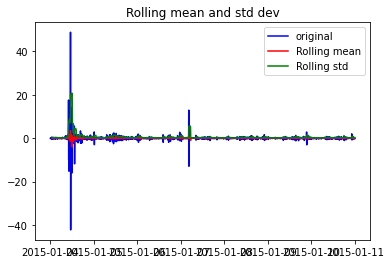

Test Statistic         -1.265183e+01
p                       1.363072e-23
lags                    2.400000e+01
number                  1.991000e+03
Critical value (1%)    -3.433639e+00
Critical value (5%)    -2.862993e+00
Critical value (10%)   -2.567543e+00
dtype: float64


/home/cdap/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


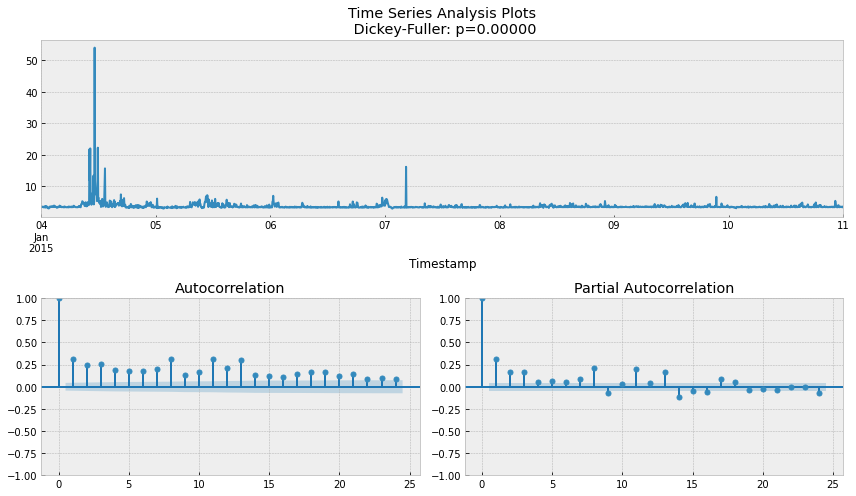

In [18]:
test_Stationary(dropped_data)
tsplot(dataset['CPU usage [%]'], lags=24)

In [19]:
ps = range(2, 7)
d=1 
qs = range(2, 7)
Ps = range(0, 7)
D=1 
Qs = range(0, 7)
s = 24 # season length is still 24

#ps = range(0, 7)
#d=1 
#qs = range(0, 7)

#Ps = range(0, 7)
#D=1 
#Qs = range(0, 7)

#s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1225

In [20]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(dataset['CPU usage [%]'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    print(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    
%time
#result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [21]:
#p, q, P, Q = result_table.parameters[0]

#best_model=sm.tsa.statespace.SARIMAX(dataset.CPU_usage_percent, order=(p, d, q), seasonal_order=(P, D, Q, s))
best_model=sm.tsa.statespace.SARIMAX(dataset['CPU usage [%]'], order=(7, 1, 5), seasonal_order=(7, 1, 5,12))

result_model=best_model.fit(disp=-1)
print(result_model.summary())

/home/cdap/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cdap/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cdap/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                      CPU usage [%]   No. Observations:                 2017
Model:             SARIMAX(7, 1, 5)x(7, 1, 5, 12)   Log Likelihood               -3484.353
Date:                            Wed, 25 May 2022   AIC                           7018.707
Time:                                    23:26:14   BIC                           7158.779
Sample:                                01-04-2015   HQIC                          7070.133
                                     - 01-11-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9971      0.103     -9.651      0.000      -1.200      -0.795
ar.L2         -0.2462      0.129   

/home/cdap/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


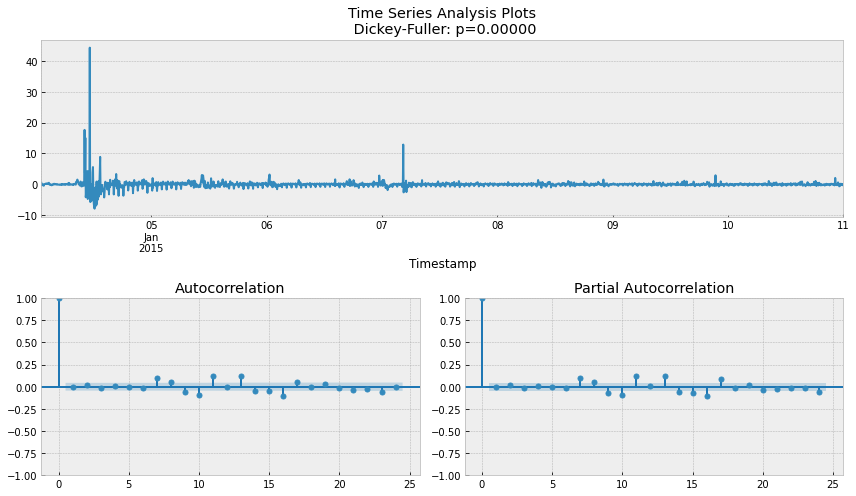

In [22]:
tsplot(result_model.resid[12+1:], lags=24)

In [23]:
from math import sqrt

2015-01-11 00:05:00    3.564137
2015-01-11 00:10:00    3.703092
2015-01-11 00:15:00    3.651456
2015-01-11 00:20:00    3.308593
2015-01-11 00:25:00    3.604745
2015-01-11 00:30:00    3.381671
2015-01-11 00:35:00    3.383116
2015-01-11 00:40:00    3.354190
2015-01-11 00:45:00    3.454820
2015-01-11 00:50:00    3.480307
2015-01-11 00:55:00    3.419481
2015-01-11 01:00:00    3.252575
2015-01-11 01:05:00    3.552054
2015-01-11 01:10:00    3.704219
2015-01-11 01:15:00    3.665800
2015-01-11 01:20:00    3.353013
2015-01-11 01:25:00    3.571296
2015-01-11 01:30:00    3.408470
2015-01-11 01:35:00    3.376763
2015-01-11 01:40:00    3.365398
2015-01-11 01:45:00    3.481269
2015-01-11 01:50:00    3.469994
2015-01-11 01:55:00    3.429391
2015-01-11 02:00:00    3.265316
2015-01-11 02:05:00    3.551406
Freq: 5T, Name: predicted_mean, dtype: float64
Test RMSE: 1.414


/tmp/ipykernel_2053/1076910729.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast = data.arima_model.append(forecast)


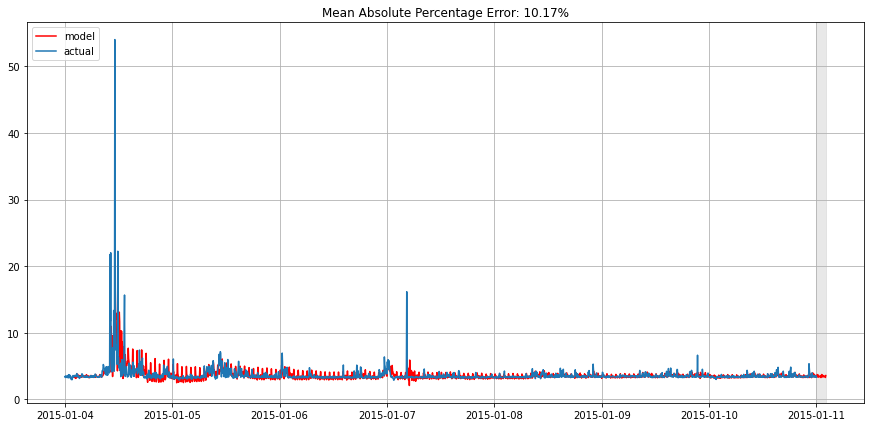

In [24]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    print(forecast)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    rmse = sqrt(mean_squared_error(data['actual'][s+d:], data['arima_model'][s+d:]))
    print('Test RMSE: %.3f' % rmse)

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

    
plotSARIMA(dataset, result_model, 24)

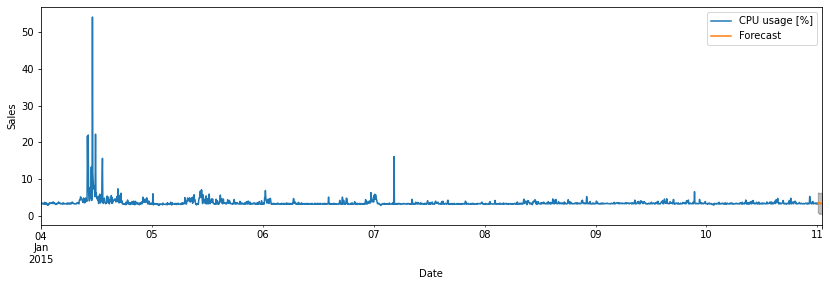

In [25]:
pred_uc = result_model.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax =dataset.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [26]:
import plotly.graph_objects as go

In [27]:
preds = pred_uc.predicted_mean.values.reshape(len(pred_uc.predicted_mean),1)

In [28]:
print(dataset.shape)

(2017, 1)


In [29]:
print(preds.shape)

(12, 1)
